<a href="https://colab.research.google.com/github/rk2026/GEOG-510/blob/main/MTanalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import necessary library (Do we need all the library listed below? can we minimize it? Do research?)

In [4]:
import os
from google.colab import drive
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from shapely.geometry import Point
from shapely.geometry import Polygon
from itertools import product
from google.colab import data_table
import math
from google.colab import files
data_table.enable_dataframe_formatter()

In case, we load necessary data from google drive so we need provide to acess our drive.

In [5]:
#drive.mount('/content/drive')

Now we already created a folder within google drive namely 'MTanalysis'. This folder contains the data we need to process

In [6]:
#data_folder = os.path.join('drive', 'My Drive', 'MTanalysis')

Read the shapefile that is the boundary of community forests from google drive's folder named **`MTanalysis`**

In [7]:
#cfouter_shp = gpd.read_file(os.path.join(data_folder, 'cfouter.shp'))

Read the CSV file. This file contains stem mapping data for each tree within the extent.

In [8]:
#treeloc_csv = pd.read_csv(os.path.join(data_folder, 'TreeLoc.csv'))
#sppVal = pd.read_csv(os.path.join(data_folder, 'sppVal.csv'))

Read the CSV file into a Pandas DataFrame

In [9]:
#df = pd.read_csv("/content/drive/MyDrive/MTanalysis/TreeLoc.csv")

Upload csv files from local computer.It will tree location data.

In [10]:
stemmapping = files.upload()

Saving TreeLoc.csv to TreeLoc.csv


In [11]:
df = pd.read_csv('TreeLoc.csv')
df

upload csv file containing species value a, b,c,a1,b1, c1, b, g, bg

In [12]:
sppVal = files.upload()

Saving sppVal.csv to sppVal.csv


In [13]:
sppVal = pd.read_csv('sppVal.csv')

upload ESRI shape file(The outer boundary of stemmapping area).

In [14]:
cfouter_shp = files.upload()

Saving cfouter.zip to cfouter.zip


plot shape file

<Axes: >

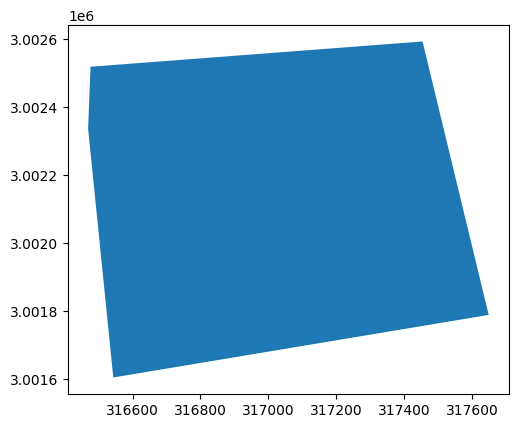

In [44]:
import geopandas as gpd
data = gpd.read_file('zip://cfouter.zip!/cfouter.shp')
data.plot()

Create a GeoDataFrame with the X and Y columns as geometry

In [45]:
geometry = gpd.points_from_xy(df["X"], df["Y"])
gdf = gpd.GeoDataFrame(df, geometry=geometry)
# Set the coordinate reference system (CRS) to UTM zone 32645
gdf.crs = "EPSG:32645"

Create fishnet and findout the centroid of the fishnet polygon

In [46]:
# Define the bounding box coordinates
min_x, min_y = gdf['X'].min(), gdf['Y'].min()
max_x, max_y = gdf['X'].max(), gdf['Y'].max()

# Define the number of rows and columns
rows = 20
cols = 20

# Calculate the width and height of each grid cell
width = (max_x - min_x) / cols
height = (max_y - min_y) / rows

# Generate the grid of polygons
polygons = []
for i, j in product(range(rows), range(cols)):
    xmin = min_x + i * width
    xmax = min_x + (i + 1) * width
    ymin = min_y + j * height
    ymax = min_y + (j + 1) * height
    polygon = Polygon([(xmin, ymin), (xmax, ymin), (xmax, ymax), (xmin, ymax)])
    polygons.append(polygon)

# Create a GeoDataFrame from the polygons
grid = gpd.GeoDataFrame(geometry=polygons, crs='EPSG:32645')

# Plot the grid
#ax = grid.plot(edgecolor='black', figsize=(10, 10))
#ax.set_xlim(min_x - 1, max_x + 1)
#ax.set_ylim(min_y - 1, max_y + 1)

In [47]:
centroid = grid.geometry.centroid

The centroid is in geoseries format. We need to convert it in geopandas dataframe format.

In [48]:
#convert geoseris to geodataframe
data = {'geometry': centroid}
# Create a GeoDataFrame from the dictionary
centroid_gdf = gpd.GeoDataFrame(data)
centroid_gdf.sindex
#centroid_gdf.plot()

Spatial join based on closest.

In [49]:
joined = gpd.sjoin_nearest(centroid_gdf,gdf, how="right", distance_col="distance")

Export shape file to drive

In [21]:
#joined.to_file("/content/drive/MyDrive/MTanalysis/joined.shp")

In [22]:
#joined.to_file("/content/drive/MyDrive/MTanalysis/joined.shp")

In [23]:
#gdf.to_file("/content/drive/MyDrive/MTanalysis/gdf.shp")

In [24]:
#centroid_gdf.to_file("/content/drive/MyDrive/MTanalysis/centroid_gdf.shp")

In [25]:
Joined_sorted = joined.sort_values(by=['index_left', 'class'], ascending=True)

:# Group the GeoDataFrame by the 'right_index' column

In [50]:
grouped_gdf = Joined_sorted.groupby('index_left')

In [51]:
first_unique_rows = grouped_gdf.head(1)

In [52]:
mt=first_unique_rows.copy()

In [53]:
# Create a copy of Joined_sorted
df_with_remarks = Joined_sorted.copy()

# Add a new column named 'Remarks'
df_with_remarks['status'] = ''

# Find the indices of TreeIDs that are in the 'mt' variable
mt_indices = df_with_remarks.index[df_with_remarks['TID'].isin(mt['TID'])]

# Update the 'Remarks' column for those indices with 'mt'
df_with_remarks.loc[mt_indices, 'status'] = 'Mother Tree'

# Print the updated DataFrame
df_with_remarks

,index_left,TID,species,X,Y,dia_cm,height_m,class,geometry,distance,status
13463,3,13468,Dalbergia sissoo,316524,3001801,67,17,1,POINT (316524.000 3001801.000),32.368696,Mother Tree
19248,3,19253,Tsuga spp,316529,3001779,39,21,1,POINT (316529.000 3001779.000),28.650175,
422,3,427,Shorea robusta,316527,3001775,60,25,2,POINT (316527.000 3001775.000),26.933854,
22304,3,22309,Shorea robusta,316529,3001801,96,17,3,POINT (316529.000 3001801.000),36.183318,
23599,3,23604,Acacia catechu,316528,3001760,81,16,4,POINT (316528.000 3001760.000),33.492275,
...,...,...,...,...,...,...,...,...,...,...,...
26961,388,26966,Anogeissus latifolia,317594,3002013,34,28,3,POINT (317594.000 3002013.000),25.201835,
3383,388,3388,Adino cordifolia,317597,3002002,87,23,4,POINT (317597.000 3002002.000),30.315549,
3741,388,3746,Quercus spp,317589,3002007,62,19,4,POINT (317589.000 3002007.000),32.671586,
10515,388,10520,Alnus nepalensis,317589,3002025,42,17,4,POINT (317589.000 3002025.000),26.665193,


In [ ]:
# Join the GeoDataFrames based on the 'species' column
merged_gdf = df_with_remarks.merge(sppVal, left_on='species', right_on='Scientific Name')
merged_gdf

In [56]:
merged_df = pd.merge(df_with_remarks, sppVal, left_on='species', right_on='Scientific Name')

In [ ]:
merged_df

stem volume calculation formula
v = EXP(a + b * ln(dia_cm) + c *ln(height_m))

In [58]:
merged_gdf['stem_volume'] = merged_gdf.apply(lambda row: math.exp(row['a'] + row['b'] * math.log(row['dia_cm']) + row['c'] * math.log(row['height_m'])), axis=1)/1000

In [ ]:
merged_gdf

In [35]:
# merged_gdf.to_csv("/content/drive/MyDrive/MTanalysis/Hello.csv")

In [ ]:
def calculate_branch_ratio(row):
    if row['dia_cm'] < 10:
        return row['s']
    elif 10 <= row['dia_cm'] < 40:
        return ((row['dia_cm'] - 10) * row['m'] + (40 - row['dia_cm']) * row['s']) / 30
    elif 40 <= row['dia_cm'] < 70:
        return ((row['dia_cm'] - 10) * row['m'] + (40 - row['dia_cm']) * row['s']) / 30
    else:
        return row['b']

merged_gdf['branch_ratio'] = merged_gdf.apply(calculate_branch_ratio, axis=1)
merged_gdf.sort_values(by='TID')

Calculate Branch volume, tree volume, 10 cm top dia ratio etc

In [60]:
merged_gdf['branch_volume'] = merged_gdf['stem_volume'] * merged_gdf['branch_ratio']
merged_gdf['tree_volume'] = merged_gdf['stem_volume'] + merged_gdf['branch_volume']
merged_gdf['cm10diaratio'] = merged_gdf['stem_volume'] + merged_gdf['branch_volume']
merged_gdf['cm10topvolume'] = gpd.np.exp(merged_gdf['a1'] + merged_gdf['b1'] * gpd.np.log(merged_gdf['dia_cm']))
merged_gdf['gross_volume'] = merged_gdf['stem_volume'] - merged_gdf['cm10topvolume']

calculating net volume using function

In [61]:
def calculate_net_volume(row):
  if row['class'] == 1:
    return row['gross_volume'] * 0.8
  elif row['class'] == 2:
    return row['gross_volume'] * 0.6
  elif row['class'] == 3:
    return row['gross_volume'] * 0.3
  else:
    return row['gross_volume'] * 0.

# Apply the function to each row in the GeoDataFrame
merged_gdf['net_volume'] = merged_gdf.apply(calculate_net_volume, axis=1)

In [62]:
# Create a new column called 'net_volum_cft'
merged_gdf['net_volum_cft'] = None

# Apply a lambda function to each row to calculate the new column value
merged_gdf['net_volum_cft'] = merged_gdf.apply(lambda row: row['net_volume'] * 3.28*3.28*3.28, axis=1)


In [63]:
# Create a new column called 'net_volum_cft'
merged_gdf['firewood_m3'] = None

# Apply a lambda function to each row to calculate the new column value
merged_gdf['firewood_m3'] = merged_gdf.apply(lambda row: row['tree_volume'] - row['net_volume'], axis=1)


In [64]:
# Create a new column called 'net_volum_cft'
merged_gdf['firewood_chatta'] = None

# Apply a lambda function to each row to calculate the new column value
merged_gdf['firewood_chatta'] = merged_gdf.apply(lambda row: row['firewood_m3'] - 0.105944, axis=1)

In [ ]:
merged_gdf

In [ ]:
merged_gdf.sort_values(by='TID')